<a href="https://colab.research.google.com/github/HeqingZ/TESTING/blob/main/NEW_SwinT3x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install detectron2
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
#import some important utilities of Detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.7 ; cuda:  cu110
detectron2: 0.5


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#import features for the bbox
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from detectron2.structures import BoxMode

In [ ]:
"""cpu"""
# !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.9/index.html
"""gpu"""    
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2==0.5 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

!pip install timm
!git clone https://github.com/emiz6413/SwinT_detectron2.git swin
!curl -OL https://github.com/xiaohu2015/SwinT_detectron2/releases/download/v1.1/faster_rcnn_swint_T.pth  # pretrained
!curl -OL https://github.com/emiz6413/SwinT_detectron2/releases/download/v1.3/model_0021209.pth  # trained

In [4]:
import os
from pathlib import Path
from ast import literal_eval

import swin
import numpy as np
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from detectron2.data import (DatasetCatalog, 
                             MetadataCatalog, 
                             build_detection_test_loader
                            )
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer, default_setup, hooks
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
 
from swin.swint import add_swint_config

logger = setup_logger()

In [ ]:
dir(swin.swint)

In [5]:
#define the file path to retrieve images
def FLIR(source_path, img_dir, anno_dir ): #define a function. assuming user doesnt know shit about coding and enter random stuff. related to anno dir and img dir
    img_dir = os.path.join(source_path, img_dir)
    anno_dir = os.path.join(source_path, anno_dir)
    data_dicts = []
    #define annotation properties
    with open(anno_dir) as F:
      jsonfile = json.load(F) #load annotations from json file into the dictionary
    
    annotationinfo = jsonfile["annotations"]
    imagesinfo = jsonfile["images"] #retreieve info like category ID and bbox
   
    #define img sources
     
    img_dir_list = os.listdir(img_dir)#get the list of all files and directories in the specified directory.
    # print(img_dir)
    for img_info in imagesinfo: #bbox info category id
      for images in img_dir_list:  #img_dir_list = img_dir, which is source_path/img_dir(original)
        images = "data/" + images
        if images == img_info['file_name']: #see if name matches each other, because we wanna find the filenames only for the small flir out of the whole json file

          record={}
          filename = os.path.join(source_path, img_info["file_name"])
          # print(filename)
          record["file_name"] = filename
          record["image_id"] = img_info['id']
          record["height"] = img_info['height']
          record['width'] = img_info['width']
        
          box_info = []
          
          for anno in annotationinfo:
            if anno["image_id"] == img_info['id']:
              # if (anno['category_id'] <= 3) & (anno['category_id'] > 0):
              if (anno['category_id'] == 1) & (anno['category_id'] > 0): # Predict people only
                        box = {
                        "bbox": anno['bbox'],
                        'bbox_mode': BoxMode.XYWH_ABS, # Category_id starts from 0 in detectron2
                        'category_id': int(anno['category_id']-1)  #we forcibly convert this shit into integer to be able to minus 1. just incase the stuff from the dict is integer
                        #computer counts from zero but not hyman. we have to substract one to match the computer #update Jun29: i deleted -1, bcz there is no category 0 
                        } #exactly how dictionary looks like
                        imagetesthaha = cv2.imread(filename, 0) 
                        tt = cv2.rectangle(imagetesthaha, anno["bbox"], (255,0,0),2)
                        #cv2_imshow(tt) #for printing all boxes in images one by one, will crash
                        box_info.append(box)
          record["annotations"] = box_info

          data_dicts.append(record)
    return data_dicts

      
      
    #print(type(jsonfile)) #check the  type of jsonfile. dict or list or stuff



#define dataloader for training and testing sets
#train_dataloader = dataloader(training_data, batch_size=64, shuffle=True)
#test_dataloader = dataloader(test_data, batch_size=64, shuffle=True)


In [6]:
def FLIR_dataset_wrapper(source_path, img_dir, anno_dir):
    def wrapper():
        return FLIR(source_path, img_dir, anno_dir)
    return wrapper

In [7]:
DatasetCatalog.clear() #unregister stuff

In [7]:
for d in ["train", "val"]:
    DatasetCatalog.register("FLIR_THERMAL_" + d + "_data", lambda d=d: FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")) #changed "/directry/stuff/" +d +"shit" into this rn
    MetadataCatalog.get("FLIR_THERMAL_" + d + "_data").set(thing_classes=["FLIR_THERMAL"])
FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")


In [9]:
convert_to_coco_json('FLIR_THERMAL_train_data', output_file='content/drive/MyDrive/output/inference/FLIR_Thermal_Train_coco_format.json', allow_cached=False)


[08/30 05:15:42 d2.data.datasets.coco]: Converting annotations of dataset 'FLIR_THERMAL_train_data' to COCO format ...)
[08/30 05:27:02 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/30 05:27:07 d2.data.datasets.coco]: Conversion finished, #images: 10742, #annotations: 50478
[08/30 05:27:07 d2.data.datasets.coco]: Caching COCO format annotations at 'content/drive/MyDrive/output/inference/FLIR_Thermal_Train_coco_format.json' ...


In [10]:
#to varify our thing by calling the function
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")


In [ ]:
!nvidia-smi

Sun Aug 14 23:35:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
'''
try parameters:
   warmup 5000
   lr 0.0001 
   ims per batch 4
   3x

'''


In [11]:
from detectron2.engine import DefaultTrainer


cfg = get_cfg()
add_swint_config(cfg)
# cfg.DATASETS.TRAIN = ("SMALL_FLIR_THERMAL_train_data",)
cfg.MODEL.RESNETS.DEPTH = 50 #for mvit v2 S we are setting the depth = 101. (F)
# cfg.DATASETS.TEST = ('SMALL_FLIR_THERMAL_val_data',)

# cfg.Dataset = ("SMALL_FLIR_THERMAL_train_data")


cfg.merge_from_file("/content/swin/configs/SwinT/faster_rcnn_swint_T_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "/content/faster_rcnn_swint_T.pth"

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people 'changed to 5'
cfg.SOLVER.BASE_LR = 0.0001 #SET ALL TO 0.0001
cfg.SOLVER.MAX_ITER = 270000    # 270000 for 3x (F)
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 5000
cfg.SOLVER.WARMUP_ITERS = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # chose 512 for 3x
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (people). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False
# cfg.MODEL.RESNETS.DEFORM_MODULATED = True
cfg.MODEL.BACKBONE.FREEZE_AT = 0
cfg.OUTPUT_DIR = "/content/drive/MyDrive/NEWSwinT3x"





#load pretrained weight
# # load pretrained weights
# other_weights = torch.load('/content/swin_tiny_patch4_window7_224_d2.pth')['model']
# self_weight = trainer.model.state_dict()
# for name, param in self_weight.items():
#     if name in other_weights:
#         if other_weights[name].shape == param.shape:
#             self_weight[name] = other_weights[name]
#         else:
#             print(f"size mismatch at {name}")
#     else:
#         print(f"layer {name} does not exist")
# trainer.model.load_state_dict(self_weight)


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[08/30 05:37:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace

/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[08/30 05:48:29 d2.utils.events]:  eta: 0:49:23  iter: 260019  total_loss: 0.5064  loss_cls: 0.1224  loss_box_reg: 0.1041  loss_rpn_cls: 0.1022  loss_rpn_loc: 0.1349  time: 0.3017  data_time: 0.0170  lr: 0.0001  max_mem: 8058M
[08/30 05:48:35 d2.utils.events]:  eta: 0:49:01  iter: 260039  total_loss: 0.5182  loss_cls: 0.1283  loss_box_reg: 0.121  loss_rpn_cls: 0.08663  loss_rpn_loc: 0.124  time: 0.2998  data_time: 0.0074  lr: 0.0001  max_mem: 8058M
[08/30 05:48:41 d2.utils.events]:  eta: 0:48:57  iter: 260059  total_loss: 0.4981  loss_cls: 0.1289  loss_box_reg: 0.1422  loss_rpn_cls: 0.07883  loss_rpn_loc: 0.1389  time: 0.3007  data_time: 0.0074  lr: 0.0001  max_mem: 8058M
[08/30 05:48:47 d2.utils.events]:  eta: 0:48:58  iter: 260079  total_loss: 0.4502  loss_cls: 0.1111  loss_box_reg: 0.1072  loss_rpn_cls: 0.09101  loss_rpn_loc: 0.1083  time: 0.3010  data_time: 0.0084  lr: 0.0001  max_mem: 8058M
[08/30 05:48:53 d2.utils.events]:  eta: 0:48:53  iter: 260099  total_loss: 0.4832  loss_cls

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [12]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # ALL THRESHOLD = 0.5
#Pass the validation dataset
cfg.DATASETS.TEST = ("boardetect_val", )

predictor = DefaultPredictor(cfg)

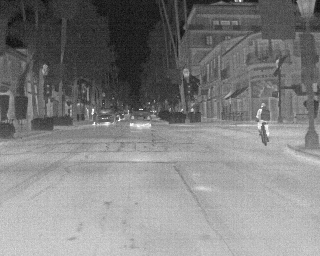

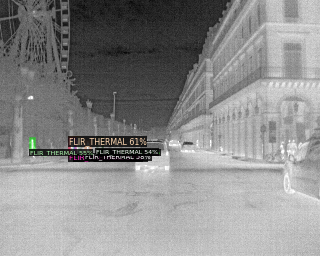

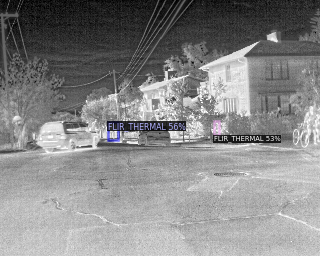

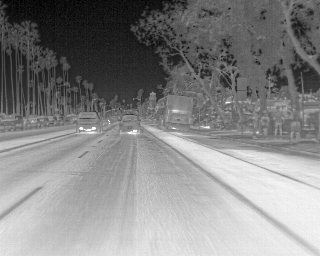

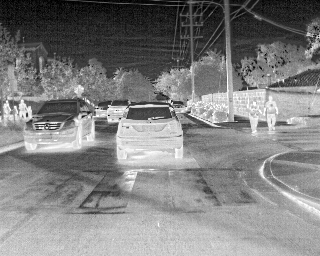

In [13]:
#see if this shit is wroking aka run instance on test images
from detectron2.utils.visualizer import ColorMode
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/val/", "data", "coco.json")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #ALL THRESHOLD = 0.5 
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("FLIR_THERMAL_train_data", cfg, False, output_dir="content/output/")
val_loader = build_detection_test_loader(cfg, "FLIR_THERMAL_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [08/30 06:50:12 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/30 06:50:12 d2.evaluation.coco_evaluation]: 'FLIR_THERMAL_train_data' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/30 06:50:12 d2.data.datasets.coco]: Converting annotations of dataset 'FLIR_THERMAL_train_data' to COCO format ...)
[08/30 07:00:44 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/30 07:00:49 d2.data.datasets.coco]: Conversion finished, #images: 10742, #annotations: 50478
[08/30 07:00:49 d2.data.datasets.coco]: Caching COCO format annotations at 'content/output/FLIR_THERMAL_train_data_coco_format.json' ...
[08/30 07:11:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/30 07:11:12 d2.data.common]: Serializin

OrderedDict([('bbox',
              {'AP': 3.1786044160013995,
               'AP50': 12.172108861329384,
               'AP75': 0.4070598514084048,
               'APs': 3.384807503419501,
               'APm': 3.1816086613370835,
               'APl': 0.0009725091911348772})])